In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [3]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_empty.json')

In [4]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [5]:
atlas = src.graph.graph_from_json('atlas.json')

In [66]:
cities = src.graph.graph_from_json('cities.json')

In [67]:
print(f'#{255:02x}{214:02x}{1:02x}')

#ffd601


In [68]:
print(f'#{193:02x}{1:02x}{120:02x}')

#c10178


In [69]:
print(f'#{63:02x}{154:02x}{11:02x}')

#3f9a0b


In [10]:
tesla = []
rivian = []
non_proprietary = []
non_tesla = []

for source, node in graph._node.items():

    if node.get('type', '') == 'station':

        if 'Tesla' in node['network']:

            tesla.append(source)

        elif 'RIVIAN' in node['network']:

            rivian.append(source)
            non_tesla.append(source)

        else:

            non_proprietary.append(source)
            non_tesla.append(source)

tesla_sng = src.graph.subgraph(graph, tesla)
rivian_sng = src.graph.subgraph(graph, rivian)
non_proprietary_sng = src.graph.subgraph(graph, non_proprietary)
non_tesla_sng = src.graph.subgraph(graph, non_tesla)

In [71]:
for source, node in graph._node.items():

    if node['type'] == 'station':

        if 'Tesla' in node['network']:

            node['plc'] = 2

        elif 'RIVIAN' in node['network']:

            node['plc'] = 1

        else:

            node['plc'] = 0
            
    else:

        node['plc'] = np.nan

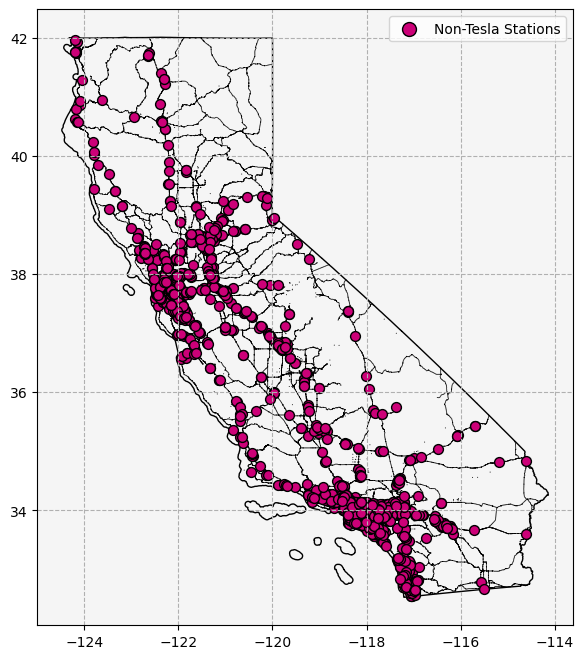

In [11]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#cc0178',
        'zorder': 1,
        'label': 'Non-Tesla Stations',
    },
}

src.figures.plot_graph(non_tesla_sng, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_NT.png', bbox_inches = 'tight', dpi = 300)

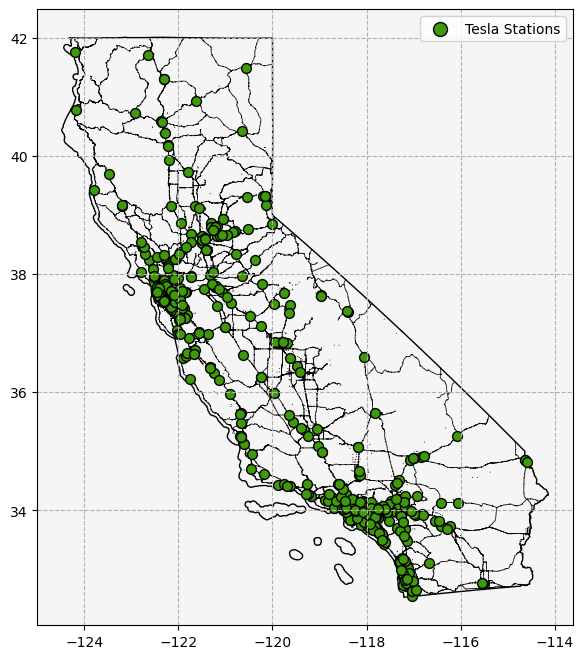

In [12]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#3f9a0b',
        'zorder': 1,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(tesla_sng, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_T.png', bbox_inches = 'tight', dpi = 300)

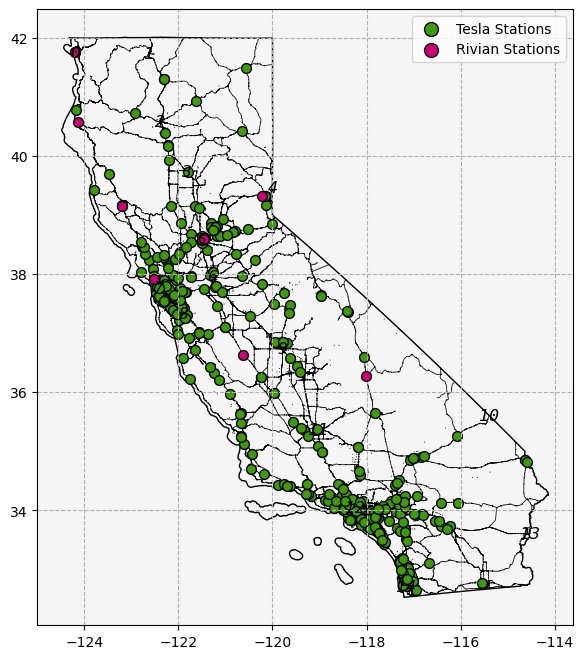

In [78]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#3f9a0b',
        'zorder': 1,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(tesla_sng, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#cc0178',
        'zorder': 2,
        'label': 'Rivian Stations',
    },
}

src.figures.plot_graph(rivian_sng, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_P_NC.png', bbox_inches = 'tight', dpi = 300)

In [79]:
for source, node in graph._node.items():

    if node['type'] != 'station':

        node['n_dcfc_d'] = np.nan

    else:

        node['n_dcfc_d'] = np.digitize(node['n_dcfc'], list(range(10)))

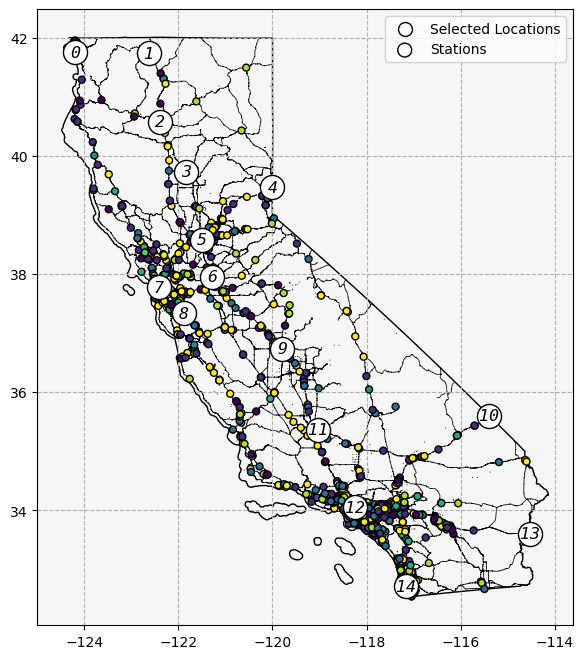

In [80]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'white',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc_d',
    'scatter': {
        's': 25,
        'ec': 'k',
        # 'fc': 'xkcd:blue',
        'zorder': 2,
        'label': 'Stations',
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

# fig.savefig('Paper/figs/California_SNG_All.png', bbox_inches = 'tight', dpi = 300)

In [81]:
np.digitize(9, [0, 1, 2, 3, 4])

5

In [82]:
for source, node in graph._node.items():

    if node['type'] != 'station':

        node['n_dcfc_r'] = np.nan

    else:

        node['n_dcfc_r'] = 0

        for target, edge in graph._adj[source].items():

            node['n_dcfc_r'] += edge['distance'] <= 200e3

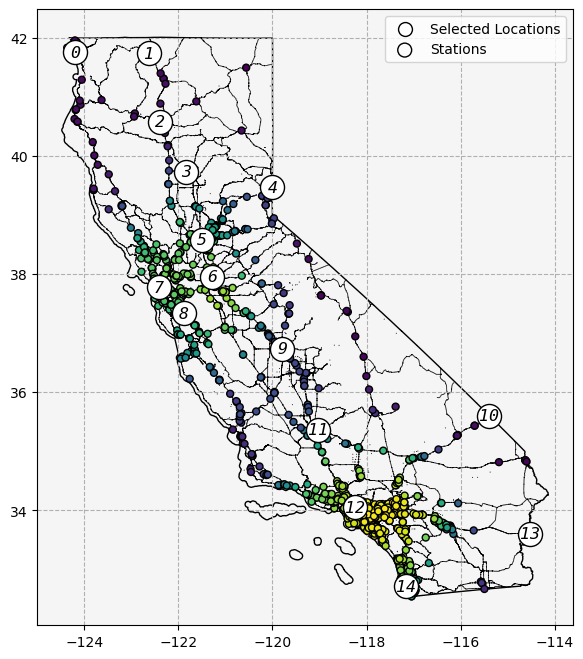

In [83]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'white',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc_r',
    'scatter': {
        's': 25,
        'ec': 'k',
        # 'fc': 'xkcd:blue',
        'zorder': 2,
        'label': 'Stations',
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

In [84]:
from scipy.stats import rv_histogram

n_np = []

for source, node in non_proprietary_sng._node.items():

    n_np.append(node['n_dcfc'])

n_t = []

for source, node in tesla_sng._node.items():
# for source, node in rivian_sng._node.items():

    n_t.append(node['n_dcfc'])

x = list(range(1, max([max(n_np), max(n_t)])))

h_np = rv_histogram(np.histogram(n_np, bins = x))
h_t = rv_histogram(np.histogram(n_t, bins = x))

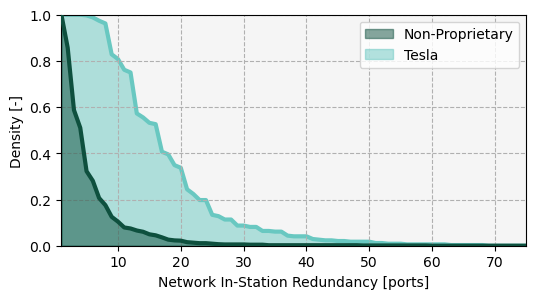

In [85]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_np.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'Non-Proprietary'
}

ax.fill_between(x, 0, h_np.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_t.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Tesla'
}

ax.fill_between(x, 0, h_t.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'Network In-Station Redundancy [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

fig.savefig('Paper/figs/California_RIS_Hist.png', bbox_inches = 'tight', dpi = 300)

In [86]:
def redundancy_between_nodes(graph, field = 'distance', cutoff = 10e3):

    graph_c = graph.copy()

    for source, adj in graph_c._adj.items():
    
        new_adj = {}
        
        for target, edge in adj.items():
    
            if edge[field] <= cutoff:
    
                new_adj[target] = edge
    
        graph_c._adj[source] = new_adj

    cliques = list(nx.find_cliques(graph_c))

    n = []
    
    for clique in cliques:
    
        n.append(sum([graph_c._node[c]['n_dcfc'] for c in clique]))

    return n

In [93]:
kw = {
    'field': 'time',
    'cutoff': 600,
}



n_np = redundancy_between_nodes(non_proprietary_sng, **kw)
n_t = redundancy_between_nodes(tesla_sng, **kw)

x = list(range(1, max([max(n_np), max(n_t)])))

h_np = rv_histogram(np.histogram(n_np, bins = x))
h_t = rv_histogram(np.histogram(n_t, bins = x))

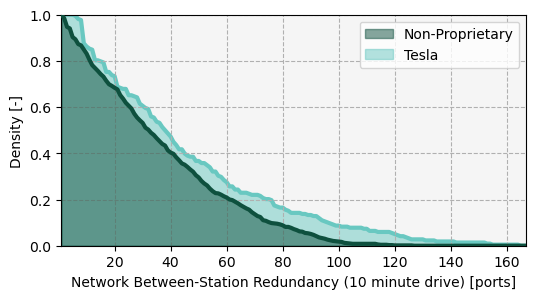

In [94]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_np.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'Non-Proprietary'
}

ax.fill_between(x, 0, h_np.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_t.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Tesla'
}

ax.fill_between(x, 0, h_t.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'Network Between-Station Redundancy (10 minute drive) [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

fig.savefig('Paper/figs/California_RBS_Hist_600.png', bbox_inches = 'tight', dpi = 300)

In [89]:
kw = {
    'field': 'time',
    'cutoff': 300,
}

n_np = redundancy_between_nodes(non_proprietary_sng, **kw)
n_t = redundancy_between_nodes(tesla_sng, **kw)

x = list(range(1, max([max(n_np), max(n_t)])))

h_np = rv_histogram(np.histogram(n_np, bins = x))
h_t = rv_histogram(np.histogram(n_t, bins = x))

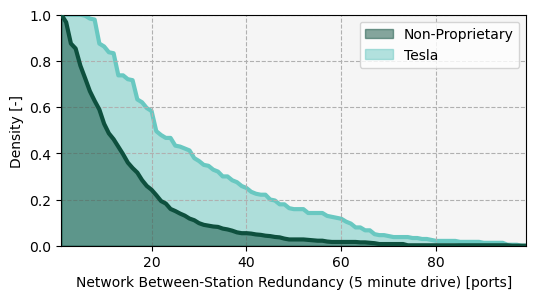

In [90]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_np.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'Non-Proprietary'
}

ax.fill_between(x, 0, h_np.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_t.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Tesla'
}

ax.fill_between(x, 0, h_t.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'Network Between-Station Redundancy (5 minute drive) [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

fig.savefig('Paper/figs/California_RBS_Hist_300.png', bbox_inches = 'tight', dpi = 300)

In [91]:
kw = {
    'field': 'time',
    'cutoff': 1200,
}

n_np = redundancy_between_nodes(non_proprietary_sng, **kw)
n_t = redundancy_between_nodes(tesla_sng, **kw)

x = list(range(1, max([max(n_np), max(n_t)])))

h_np = rv_histogram(np.histogram(n_np, bins = x))
h_t = rv_histogram(np.histogram(n_t, bins = x))

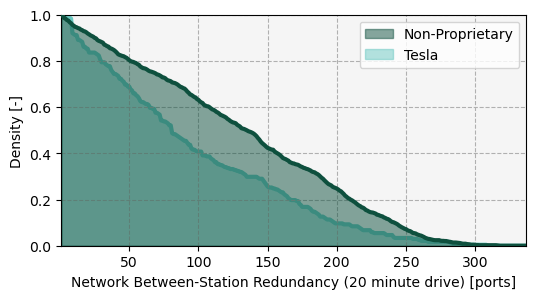

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_np.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'Non-Proprietary'
}

ax.fill_between(x, 0, h_np.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_t.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Tesla'
}

ax.fill_between(x, 0, h_t.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'Network Between-Station Redundancy (20 minute drive) [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

fig.savefig('Paper/figs/California_RBS_Hist_1200.png', bbox_inches = 'tight', dpi = 300)

In [8]:
from scipy.stats import rv_histogram

def redndancy_in_station(graph, networks):

    n = []

    for source, node in graph._node.items():

        network = node.get('network', 'none')

        # print(network)

        if network in networks:

            n.append(node['n_dcfc'])

    # print(n)

    x = list(range(1, max([max(n), 5])))

    h = rv_histogram(np.histogram(n, bins = x))

    return x, n, h

In [15]:
networks = np.unique([n.get('network', 'none') for n in graph._node.values()])

In [16]:
networks

array(['7CHARGE', 'Blink Network', 'CHARGELAB', 'CIRCLE_K',
       'ChargePoint Network', 'EV Connect', 'EVCS', 'EVGATEWAY',
       'EVRANGE', 'Electrify America', 'FLO', 'LOOP', 'Non-Networked',
       'POWERFLEX', 'RIVIAN_ADVENTURE', 'SHELL_RECHARGE', 'SWTCH',
       'Tesla', 'Volta', 'eVgo Network', 'none'], dtype='<U19')

In [17]:
out = redndancy_in_station(graph, ['ChargePoint Network'])

In [6]:
combinations = [
    ['ChargePoint Network'],
    ['Electrify America'],
    ['eVgo Network'],
    ['FLO'],
    ['Volta'],
    ['RIVIAN_ADVENTURE'],
    ['Tesla'],
    ['7CHARGE', 'Blink Network', 'CHARGELAB', 'CIRCLE_K',
     'EV Connect', 'EVCS', 'EVGATEWAY',
     'EVRANGE', 'LOOP', 'Non-Networked',
     'POWERFLEX', 'SHELL_RECHARGE', 'SWTCH'],
]

labels = (
    ['ChargePoint', 'Electrify America', 'eVgo', 'FLO', 'Volta', 'Rivian', 'Tesla', 'Other']
)

In [12]:
subgraphs = {}

for idx, label in enumerate(labels):

    comb = combinations[idx]

    nodes = [k for k, v in graph._node.items() if v.get('network', '') in comb]

    subgraphs[label] = src.graph.subgraph(graph, nodes)

In [14]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    x_i, n_i, h_i = src.analysis.redundancy_in_station(subgraphs[labels[idx]])
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

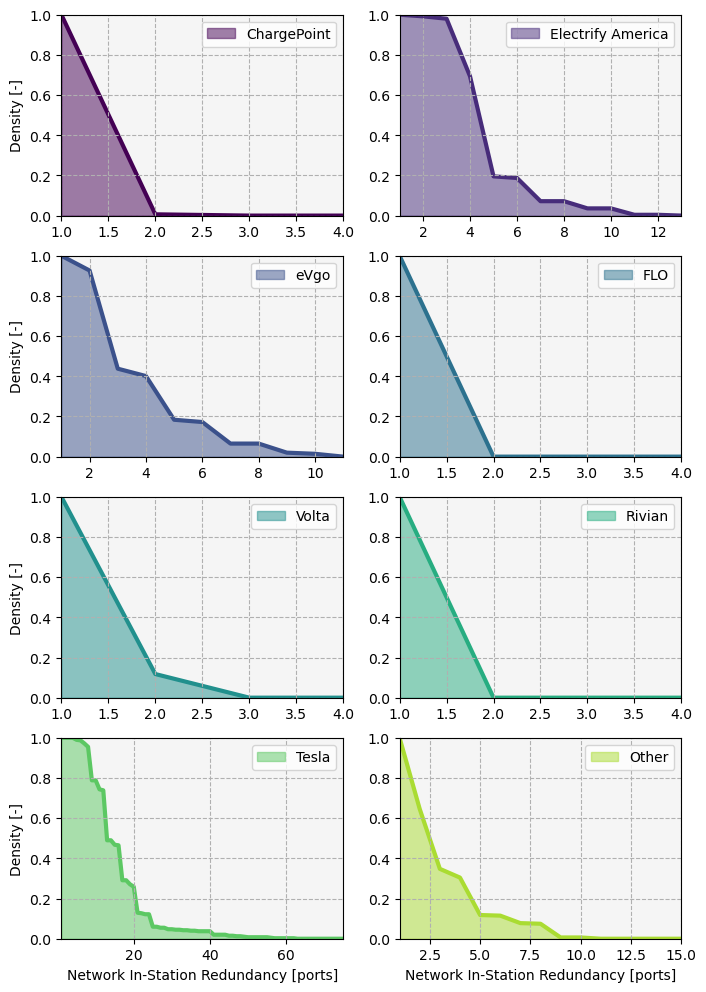

In [15]:
m = 8
rows = 4
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (4 * columns, 3 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend()

        idx += 1

# fig.savefig('Paper/figs/California_RIS_SF_All.png', bbox_inches = 'tight', dpi = 300)

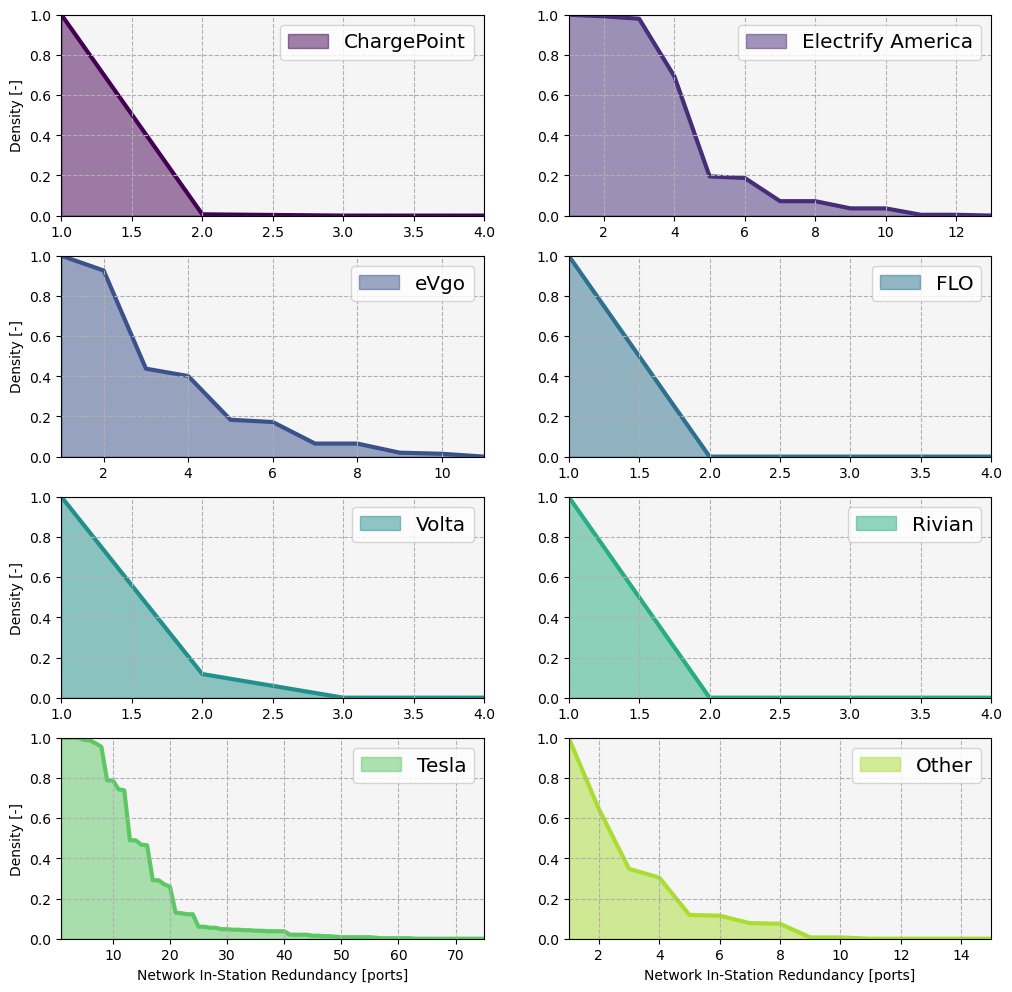

In [23]:
# m = len(combinations)

m = 8
rows = 4
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (6 * columns, 3 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend(fontsize = 'x-large')

        idx += 1

fig.savefig('Paper/figs/California_RIS_SF_All_Pres.png', bbox_inches = 'tight', dpi = 300)

In [34]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    x_i, n_i, h_i = src.analysis.redundancy_between_stations(
        subgraphs[labels[idx]], field = 'time', cutoff = 300,
    )
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

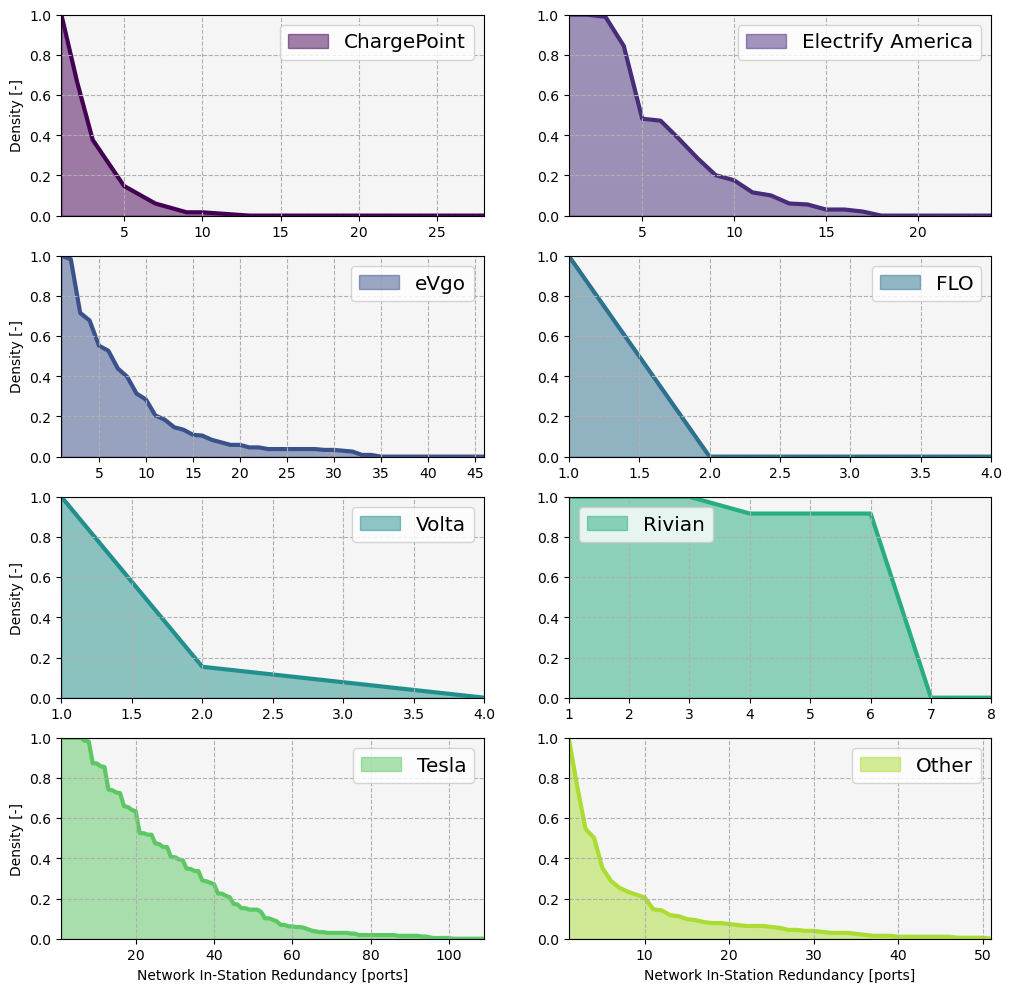

In [36]:
# m = len(combinations)

m = 8
rows = 4
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (6 * columns, 3 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend(fontsize = 'x-large')

        idx += 1

fig.savefig('Paper/figs/California_RBS_300_SF_All.png', bbox_inches = 'tight', dpi = 300)

In [37]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    x_i, n_i, h_i = src.analysis.redundancy_between_stations(
        subgraphs[labels[idx]], field = 'time', cutoff = 600,
    )
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

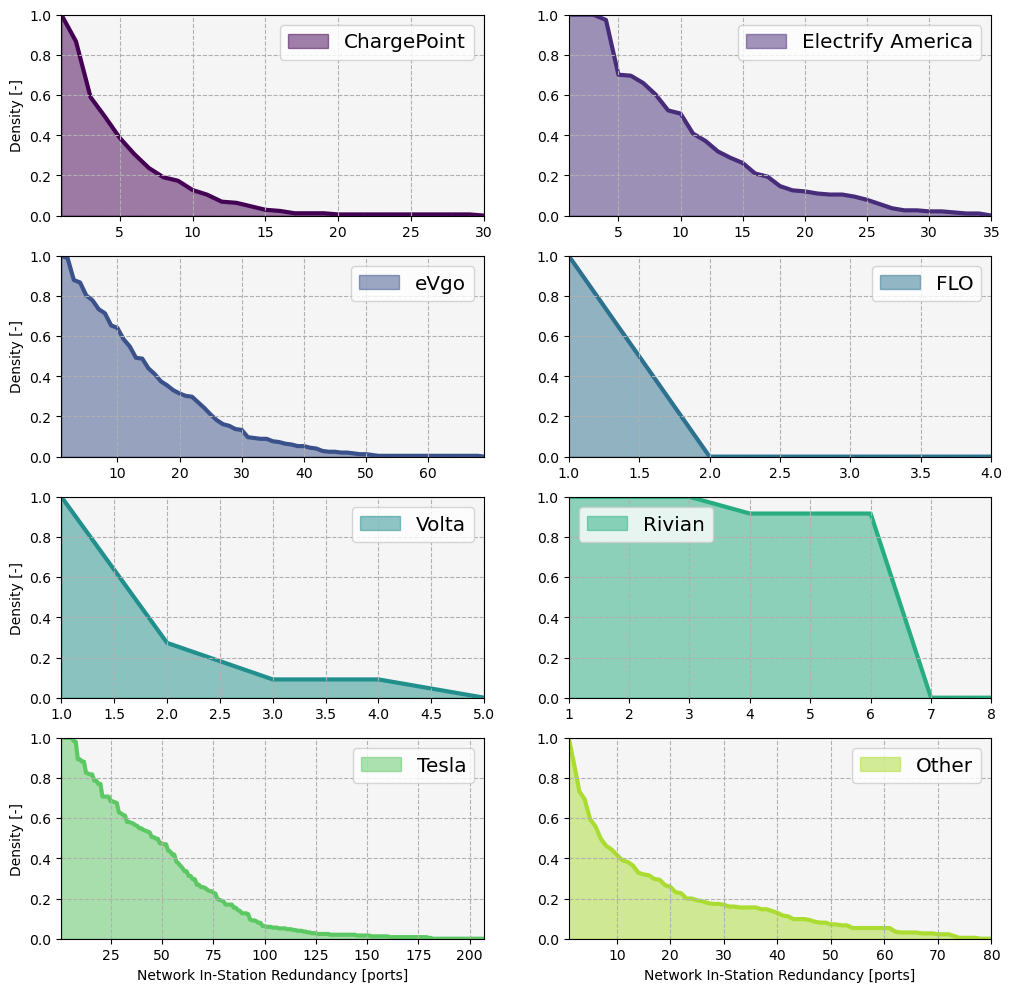

In [38]:
# m = len(combinations)

m = 8
rows = 4
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (6 * columns, 3 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend(fontsize = 'x-large')

        idx += 1

fig.savefig('Paper/figs/California_RBS_600_SF_All.png', bbox_inches = 'tight', dpi = 300)

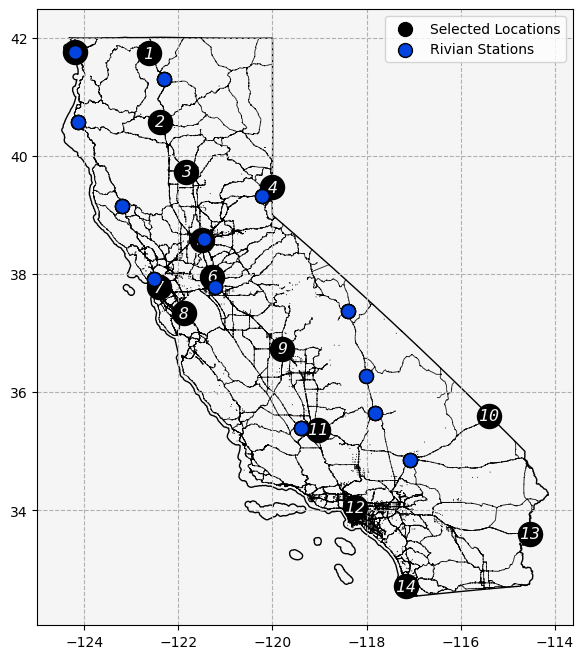

In [61]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'k',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
    'color': 'whitesmoke',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 100,
        'ec': 'k',
        'fc': 'xkcd:blue',
        'zorder': 6,
        'label': 'Rivian Stations',
    },
}

src.figures.plot_graph(subgraphs['Rivian'], ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_Rivian_SNG_All.png', bbox_inches = 'tight', dpi = 300)

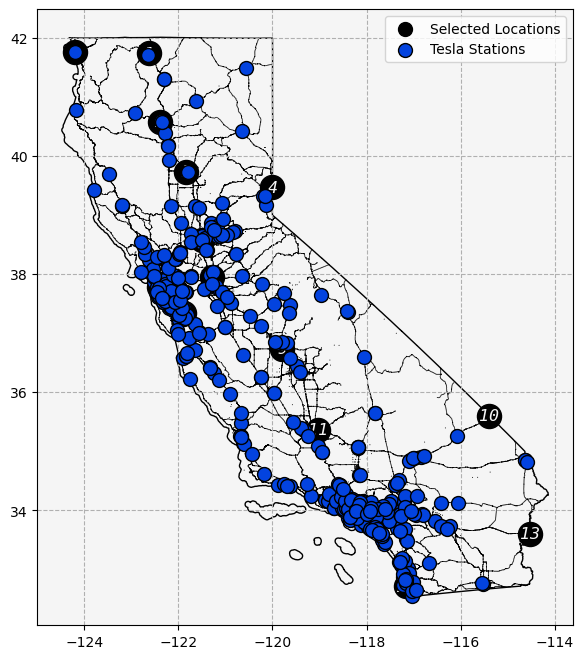

In [60]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'k',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
    'color': 'whitesmoke',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 100,
        'ec': 'k',
        'fc': 'xkcd:blue',
        'zorder': 6,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(subgraphs['Tesla'], ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_Tesla_SNG_All.png', bbox_inches = 'tight', dpi = 300)

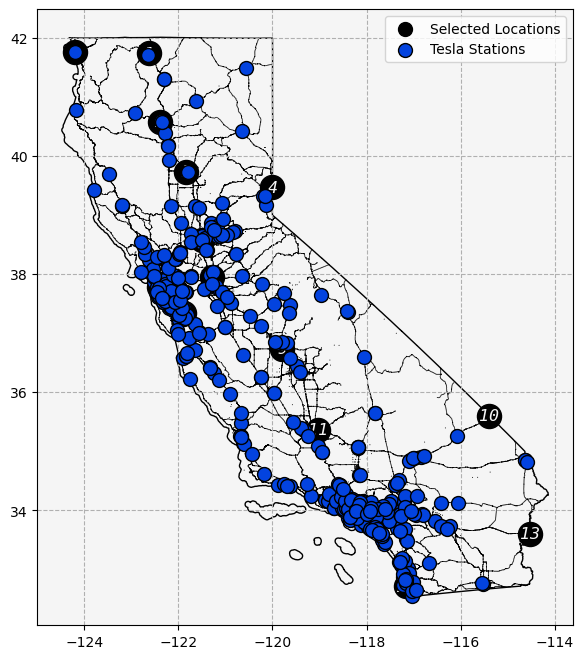

In [60]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'k',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
    'color': 'whitesmoke',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 100,
        'ec': 'k',
        'fc': 'xkcd:blue',
        'zorder': 6,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(subgraphs['Tesla'], ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_Tesla_SNG_All.png', bbox_inches = 'tight', dpi = 300)